# PIE facial database

In [1]:
# http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html
# https://github.com/jindongwang/transferlearning/blob/master/data/dataset.md
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score

In [2]:
fea = pd.read_csv("fea64.csv", header=None) 
gnd = pd.read_csv("gnd64.csv", header=None) 

In [3]:
print('fea:', fea.shape) # each row is a 64x64 image (11554 examples)
print('gnd:', gnd.shape) # label: 68 classes corresponding to the 68 subjects (11554 examples) 

fea: (11554, 4096)
gnd: (11554, 1)


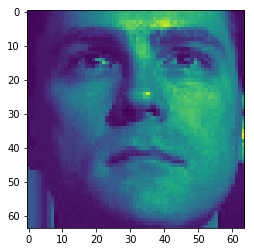

In [4]:
ind = np.random.randint(fea.shape[0])
img = fea.values[ind,:].reshape(64,64).T
imgplot = plt.imshow(img)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(fea, gnd, test_size=0.95)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(577, 4096) (577, 1)
(10977, 4096) (10977, 1)


# Principal Component Analysis (PCA)

Given a collection of of n m-dimensional samples stored in the columns of matrix $X = [x_1 , . . . , x_n ]$. We also assume that data are centered. Otherwise, we can always substract the mean $m = \frac{1}{n} \sum_{i=1}^{n}x_i$.

An efficient way of doing this is:

\begin{align*}
X − M = X \left(I − \frac{1}{n}1_n1_n^T \right)
\end{align*}

## Statistical perspective
We want to find the vector $w$ such that the variance of the projected features $y_i = w_i^Tx_i$ is maximised.The variance can be expressed:

\begin{align*}
\sigma_y^2 = \frac{1}{n} \sum_{i=1}^{n}(y_i - \mu_y)
\end{align*}

Where $\mu_y$ is the mean. Since we supposed the data are centered, $\mu_y = 0$.

The maximiser is:

\begin{align*}
w^* & = \mathrm{argmax}_{w} \frac{1}{2n} \sum_{i=1}^{n}(w^Tx_i)^2 = \mathrm{argmax}_{w}  \frac{1}{2n} \sum_{i=1}^{n}w^Tx_i x_i^Tw\\
& = \mathrm{argmax}_{w} \frac{1}{2} w^T\frac{XX^T}{n}w  = \mathrm{argmax}_{w} \frac{1}{2} w^T S_tw  
\end{align*}

Where $S_t = \frac{XX^T}{n}$ is called the covariance matrix (or total-scatter matrix). We add the following constraint not to end up with a trivial solution $w=\infty$.

\begin{align*}
w^*  &= \mathrm{argmax}_{w} \frac{1}{2} w^T S_tw \\
\text{subject to } &w^Tw=1
\end{align*}

The corresponding Lagrangian is:

\begin{align*}
L(w, \lambda) = \frac{1}{2}w^TS_tw - \lambda(w^Tw-1)
\end{align*}

Taking the derivative:
\begin{align*}
\frac{ \partial L}{\partial w} = S_tw - \lambda w = 0
\end{align*}

This means $w$ is an eigenvector of $S_t$, and $\lambda$ the corresponding eigenvalue. Plugging back this expression in the initial problem:

\begin{align*}
\lambda^* = \mathrm{argmax}_{\lambda} \lambda
\end{align*}

So the largest eigenvalue is chosen.

This reasonning can be applied for $y_i \in \mathbb{R}^d$:

\begin{align*}
W^* =& \mathrm{argmax}_{W} \frac{1}{2n} \sum_{k=1}^{d} \sum_{i=1}^{n} y_{ki}^2  = \mathrm{argmax}_{W} \frac{1}{2n} \sum_{k=1}^{d} \sum_{i=1}^{n} (w_k^Tx_i)^2 \\
& = \mathrm{argmax}_{W} \frac{1}{2n} \sum_{k=1}^{d} \sum_{i=1}^{n} w_k^Tx_ix_i^Tw_k \\
& = \mathrm{argmax}_{W} \frac{1}{2n} \sum_{k=1}^{d}  w_k^T \left(\sum_{i=1}^{n}x_ix_i^T \right)w_k \\
& = \mathrm{argmax}_{W} \frac{1}{2} \sum_{k=1}^{d}  w_k^T S_t w_k \\
& = \mathrm{argmax}_{W} \frac{1}{2} \mathrm{Tr} (W^T S_t W) \\
\end{align*}

So the general problem is:

\begin{align*}
\max_W \mathrm{Tr} (W^T S_tW) \\
\text{subject to } &W^TW=1
\end{align*}

Taking the partial derivative of the Lagrangian leads to a similar condition:

\begin{align*}
S_tW=W\Lambda
\end{align*}

Where $\Lambda$ is the matrix of the Lagrange multipliers.

Assuming the eigendecomposition of $S_t$ is $S_t = U \Lambda U^T$, then $W = U_d = [u_1, ..., u_d]$.

Similarly as above, the cost function can be written as:

\begin{align*}
    \mathrm{Tr}(W^TS_TW) = \mathrm{Tr}(W^T U \Lambda U^T W) = \mathrm{Tr}(\Lambda_d) = \sum_{k=1}^{d} \lambda_k
\end{align*}

Since $\lambda_k \ge 0$, maximisation of the above is equivalent to take the $d$ largest eigenvalues.

## Practical computation
The way of doing this is similar to the mathematical proof above, except for computing the eigenvectors / eigenvalues.

Since we assume the number of features is large compared to the number of examples ($m \ge n$), instead of applying eigenanalysis of $X^T X$, we compute them on $X X^T$ of dimension $m \times m$ ($X$ is the matrix of the column vector $x_i$). The eigenvalues of the two matrices are the same. The eigenvectors are not and can be computed this way:

\begin{align*}
U = X V \Lambda ^{- \frac{1}{2}}
\end{align*}

The full procedure is:
1. Compute dot product matrix: $X^T X = (x_i − m)^T (x_i − m)$
2. Eigenanalysis: $X^T X = VΛV T$
3. Compute eigenvectors: $U = XVΛ^{-\frac{1}{2}}$ ( for the whitened PCA: $U = XVΛ^{-1}$)
4. Keep specific number of first components: $U_d = (u_1, ..., u_d)$
5. Compute d features: $Y = U_d^T X$

## Algorithm (PCA)

In [6]:
def PCA_py(data, dim):
    data = data.values
    
    n, m = data.shape
    
    mean = 1/n*np.sum(data, axis = 0)
    data = data - mean
    
    #data = data.T @ (np.eye(n) - 1/n*np.ones((n, 1)) @ np.ones((1, n)))
    
    St = data @ data.T
    
    w, v = np.linalg.eig(St)
    
    idx = w.argsort()[::-1]   
    w = w[idx]
    w = np.diag(w)
    v = v[:,idx]
    
    w_inv = np.linalg.inv(w)
    w_inv[w_inv <0] = 0
    
    u = data.T @ v @ w_inv**0.5
    
    np.nan_to_num(u)
    
    u_red = u[:,:dim]
    
    y = data @ u_red
    
    np.nan_to_num(y)
    
    data_reconstruct = y @ u_red.T + mean
    
    return u_red, y, data_reconstruct

## Plot in 2D

In [7]:
pca = PCA(n_components=2)
pca_sk = pca.fit_transform(StandardScaler().fit_transform(X_train.astype(float)))

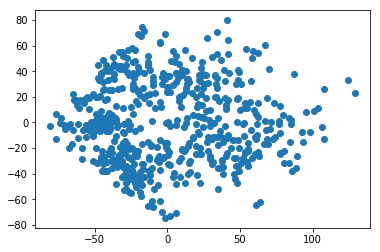

In [8]:
plt.scatter(pca_sk[:,0], pca_sk[:,1])

In [9]:
u_red, pca_py, data_re = PCA_py(X_train, 2)

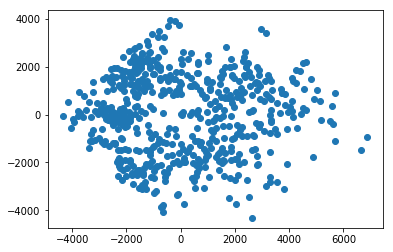

In [10]:
plt.scatter(pca_py[:,0], pca_py[:,1])

## Algorithm (wPCA)

In [11]:
def wPCA_py(data, dim):
    data = data.values
    
    n, m = data.shape
    
    mean = 1/n*np.sum(data, axis = 0)
    data = data - mean
    
    #data = data.T @ (np.eye(n) - 1/n*np.ones((n, 1)) @ np.ones((1, n)))
    
    St = data @ data.T
    
    w, v = np.linalg.eig(St)
    
    idx = w.argsort()[::-1]   
    w = w[idx]
    w = np.diag(w)
    v = v[:,idx]
    
    w_inv = np.linalg.inv(w)
    w_inv[w_inv <0] = 0
    
    u = data.T @ v @ w_inv
    
    np.nan_to_num(u)
    
    u_red = u[:,:dim]
    
    y = data @ u_red
    
    np.nan_to_num(y)
    
    data_reconstruct = y @ u_red.T + mean
    
    return u_red, y, data_reconstruct

#  Linear Discriminant Analysis (LDA)

The PCA is an unsupervised approach, good for compression of data and data reconstruction, but it does not take advantage of the labels. The Linear Discriminant Analysis (LDA) tries to define a latent space in this case.

The main idea is that:
- the  data consisting each class look more like each other: minimize the variance inner class,
- the data of separate classes look more dissimilar: increase the distance between their means.

We can define the within-class scatter matrix as:

\begin{align*}
S_w = \sum_{j=1}^{C}\frac{1}{N_{c_j}} \sum_{x_i \in c_j}(x_i - \mu(c_j))(x_i - \mu(c_j))^T
\end{align*}

Where $C$ is the number of classes, and $N_{c_j}$ the number of examples in the class $c_j$.

The between-class scatter matrix is:

\begin{align*}
S_b = \sum_{j=1}^{C}(\mu(c_j)-m)(\mu(c_j)-m)^T
\end{align*}

Since the two matrices have been defined for $x$, and we want to make the optimisation on the $y = W^T x$, we are looking for $W$ such that the following ratio is maximized:

\begin{align*}
\frac{W^T S_b W}{W^T S_w W}
\end{align*}

This is equivalent to solve the optimisation problem:

\begin{align*}
\max \mathrm{Tr} (W^T S_b W) \text{ s.t. } W^T S_w W =I
\end{align*}

The Lagrangian of the problem is:

\begin{align*}
L(W, \Lambda) = \mathrm{Tr}(W^T S_b W) - \mathrm{Tr}(\Lambda (W^T S_w W - I))
\end{align*}

Taking the partial derivative with respect to $W$:

\begin{align*}
\frac{ \partial L}{\partial W} = 2 S_b W - 2 S_w W \Lambda = 0
\end{align*}

So:

\begin{align*}
S_b W = S_w W \Lambda
\end{align*}

As a result, the column of $W$ are the eigenvectors of $S_w^{-1}S_b$.

To deal with the potential singularity of the $S_w$, we can apply the following steps:
- perform PCA on our data matrix $X$ ro reduce the dimensions to $n - (C+1)$ using the eigenvectors $U$,
- solve LDA on this reduced space ($Y = U^TX$) and get optimal matrix $Q$ that has $C-1$ column,
- compute the total transformation as $W = UQ$.

To avoid loss of information, the proper way to do that is called 'simultaneous diagolisation procedure'.

## Practical computation
The full procedure is:
1. find the eigenvectors of $S_w$ that correspond to the non-zero eigenvalues (usually $n − (C + 1)$), ie $U = (u_1, ..., u_{n−(C+1)})$ by performing eigen-analysis to $(I − M)X^T X(I − M) = V_w \Lambda_w V_w^T$ and computing $U = X(I − M)V_w Λ_w^{−1}$ (performing whitening on $S_w$),
2. Project the data as $X_b = U^T X M$,
3. Perform PCA on $X_b$ to find $Q$ (compute the eigenanalysis of $X_b X_b^T = Q \Lambda_b Q^T$),
4. The total transform is $W = UQ$.

## Algorithm

In [12]:
def LDA(data, labels, dim_PCA):
    data = data.values
    
    n, m = data.shape

    C = labels.iloc[:,0].value_counts().shape[0] #calculating the number of classes

    M = np.zeros((n, n)) #creating a huge matrix M to store all the Ei

    j = 0 #index of the matrix Ei

    for i in range(1,C):

        tempX = data[labels[0] == i,:] #xi corresponding to the current class

        n_i = tempX.shape[0] #number of elements corresponding to the given class

        E = np.ones((n_i, n_i)) * 1/n_i #building the matrix Ei

        M[j:j+n_i,j:j+n_i] = E #putting the matrix Ei in the huge matrix M

        j = j+n_i; #calculating the index of the position of the next matrix E_i+1

    MI = np.eye(n) - M #defining "MI" to simplify further equation

    dim = n - (C+1) #defining "dim" to simplify further equation

    w, v = np.linalg.eig(MI @ data @ data.T @ MI)
    
    idx = w.argsort()[::-1]   
    w = w[idx]
    w = np.diag(w)
    v = v[:,idx]
    
    w = w[:dim,:dim]
    v = v[:,:dim]
    
    U = data.T @ MI @ v @ np.linalg.inv(w)
    
    Xb = U.T @ data.T @ M
    
    Xb = pd.DataFrame(Xb)
    
    Q = PCA_py(Xb.T,dim_PCA)[0] #computing PCA on the projected matrix
    
    W = U @ Q #compute the final projection matrix
    
    W = np.real(W)
    
    y = data @ W
    
    np.nan_to_num(y)
    
    data_reconstruct = y @ W.T
    
    return W, y, data_reconstruct

# Precision

In [14]:
def knn(dim_red_algo, X_train, X_test, y_train, y_test):
    mse_table = []
    precision_table = []
    data_re_table = []
    for i in range(1,65):
        if dim_red_algo == LDA:
            u_red, y, data_re = dim_red_algo(X_train, y_train, i)
        else:
            u_red, y, data_re = dim_red_algo(X_train, i)
            
        mse = ((X_train.values - data_re)**2).mean()
        mse_table.append(mse)
        
        data_re_table.append(data_re)
        
        X_train_red = X_train @ u_red
        X_test_red = X_test @ u_red
        
        neigh = KNeighborsClassifier(n_neighbors=1)
        neigh.fit(X_train_red, y_train.values.ravel())
        y_pred = neigh.predict(X_test_red)
        precision = precision_score(y_test, y_pred, average='micro')
        precision_table.append(precision)
    
    return mse_table, precision_table, data_re_table

In [15]:
mse_table_wPCA, precision_table_wPCA, data_re_wPCA = knn(wPCA_py, X_train, X_test, y_train, y_test)

In [19]:
precision_table_PCA = knn(PCA_py, X_train, X_test, y_train, y_test)[1]
precision_table_wPCA = knn(wPCA_py, X_train, X_test, y_train, y_test)[1]
precision_table_LDA = knn(LDA, X_train, X_test, y_train, y_test)[1]

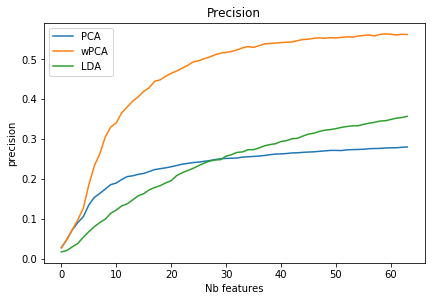

In [20]:
plt.figure(figsize=(15,15))

plt.subplot(321)
plt.plot(precision_table_PCA, label='PCA')
plt.plot(precision_table_wPCA, label='wPCA')
plt.plot(precision_table_LDA, label='LDA')
plt.xlabel('Nb features')
plt.ylabel('precision')
plt.title('Precision')
plt.legend()


plt.show()